# Time-indexed Job-Shop

$$
\begin{align}
    \text{min} \quad & C \\
    \text{s.t.} \quad & \sum_{t \in T}{y_{m, j, t}} = 1
        & \forall ~ j \in J; m \in M \\
    & \sum_{j \in J} x_{m, j, t} \leq 1
        & \forall ~ m \in M; t \in T \\
    & \sum_{t \in T}{(t + p_{\sigma_{h - 1}^j, j}) y_{\sigma_{h - 1}^j, j, t}} \leq
    \sum_{t \in T}{t y_{\sigma_{h}^j, j, t}}
        & \forall ~ j \in J; h \in (1, 2, ..., |M|) \\
    & y_{m, j, t} \leq x_{m, j, t}
        & \forall ~ m \in M; j \in J; t \in T \\
    & y_{m, j, t} \leq 1 - x_{m, j, t - 1}
        & \forall ~ m \in M; j \in J; t \in T \setminus \{0\} \\
    & x_{m, j, t} - x_{m, j, t - 1} \leq y_{m, j, t}
        & \forall ~ m \in M; j \in J; t \in T \setminus \{0\} \\
    & t x_{m, j, t} \leq C
        & \forall ~ m \in M; j \in J; t \in T \\

    & y_{m, j, t}, x_{m, j, t} \in \{0, 1\} & \forall ~ j; m \in M; t \in T\\
\end{align}
$$

In [1]:
import json
import os

import numpy as np
import pyomo.environ as pyo
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
with open(os.path.join("data", "random_3_4.json"), mode="r") as file:
    data = json.load(file)

In [3]:
machines = sorted(data["technology"][0])
jobs = list(range(len(data["technology"])))
processing = {
    (record["machine"], record["job"]): record["time"]
    for record in data["processing"]
}
sequences = [
    (m1, row[h + 1], j)
    for j, row in enumerate(data["technology"])
    for h, m1 in enumerate(row[:-1])
]

## pyomo

In [4]:
model = pyo.ConcreteModel()

In [5]:
# Sets for machines, jobs, horizon, and job sequences
model.M = pyo.Set(initialize=machines)
model.J = pyo.Set(initialize=jobs)
model.T = pyo.Set(initialize=range(sum(p for p in processing.values())))
model.Sigma = pyo.Set(initialize=sequences)

In [6]:
# Parameters
model.p = pyo.Param(model.M, model.J, initialize=processing)

In [7]:
# Variables
model.x = pyo.Var(model.M, model.J, model.T, within=pyo.NonNegativeReals, bounds=(0, 1))
model.y = pyo.Var(model.M, model.J, model.T, within=pyo.Binary)
model.C = pyo.Var(within=pyo.NonNegativeReals)

In [8]:
# Constraints
def cstr_unique_start(model, m, j):
    return sum(model.y[m, j, :]) == 1


def cstr_unique_machine(model, m, t):
    return sum(model.x[m, :, t]) <= 1


def cstr_tech_order(model, m1, m2, j):
    lhs = sum(
        (t + model.p[m1, j]) * model.y[m1, j, t]
        for t in model.T
    )
    rhs = sum(
        t * model.y[m2, j, t]
        for t in model.T
    )
    return lhs <= rhs


def cstr_duration(model, m, j, t):
    if t <= model.T.last() - model.p[m, j]:
        lhs = model.p[m, j] * model.y[m, j, t]
        rhs = sum(model.x[m, j, t2] for t2 in range(t, t + model.p[m, j]))
        return lhs <= rhs
    else:
        return model.y[m, j, t] == 0.0


def cstr_duration_comp(model, m, j):
    return sum(model.x[m, j, :]) == model.p[m, j]


def cstr_start_c1(model, m, j, t):
    return model.y[m, j, t] <= model.x[m, j, t]


def cstr_start_c2(model, m, j, t):
    if t != model.T.first():
        t_prev = model.T.prev(t)
        return model.y[m, j, t] <= 1 - model.x[m, j, t_prev]
    else:
        return pyo.Constraint.Skip


def cstr_start_c3(model, m, j, t):
    if t != model.T.first():
        t_prev = model.T.prev(t)
        return model.x[m, j, t] - model.x[m, j, t_prev] <= model.y[m, j, t]
    else:
        return pyo.Constraint.Skip


def cstr_total_time(model, m, j, t):
    return t * model.x[m, j, t] <= model.C

In [9]:
model.cstr_unique_start = pyo.Constraint(model.M, model.J, rule=cstr_unique_start)
model.cstr_unique_machine = pyo.Constraint(model.M, model.T, rule=cstr_unique_machine)
model.cstr_tech_order = pyo.Constraint(model.Sigma, rule=cstr_tech_order)
model.cstr_duration = pyo.Constraint(model.M, model.J, model.T, rule=cstr_duration)
model.cstr_duration_comp = pyo.Constraint(model.M, model.J, rule=cstr_duration_comp)
model.cstr_start_c1 = pyo.Constraint(model.M, model.J, model.T, rule=cstr_start_c1)
model.cstr_start_c2 = pyo.Constraint(model.M, model.J, model.T, rule=cstr_start_c2)
model.cstr_start_c3 = pyo.Constraint(model.M, model.J, model.T, rule=cstr_start_c3)
model.cstr_total_time = pyo.Constraint(model.M, model.J, model.T, rule=cstr_total_time)

In [10]:
# Objective
model.obj = pyo.Objective(expr=model.C + 1, sense=pyo.minimize)

## Solve

In [11]:
solver = pyo.SolverFactory("appsi_highs")
solver.options["mip_heuristic_effort"] = 0.2
solver.options["time_limit"] = 180
solver.options["log_file"] = "Highs.log"
solver.solve(model, tee=True)

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
8696 rows, 3336 cols, 42733 nonzeros
7834 rows, 3046 cols, 36647 nonzeros

Solving MIP model with:
   7834 rows
   3046 cols (1305 binary, 0 integer, 0 implied int., 1741 continuous)
   36647 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   1               inf                  inf        0      0      0         0     5.1s
         0       0         0   0.00%   5.059816955     inf                  inf        0      0     12      4466     7.2s
 R       0       0         0   0.00%   5.096864794     143               96.44%     9448    590     50      7270    12.5s
         0       0         0   0.00%   6.429257944     143   

{'Problem': [{'Lower bound': 21.110663209729605, 'Upper bound': 143.0, 'Number of objectives': 1, 'Number of constraints': 0, 'Number of variables': 0, 'Sense': 1}], 'Solver': [{'Status': 'aborted', 'Termination condition': 'maxTimeLimit', 'Termination message': 'TerminationCondition.maxTimeLimit'}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [12]:
def get_plot_elements(model, j):
    machines = [y.index()[0] for y in model.y[:, j, :] if np.isclose(y.value, 1, atol=1e-1)]
    starts = [y.index()[2] for y in model.y[:, j, :] if np.isclose(y.value, 1, atol=1e-1)]
    spans = [model.p[m, j] for m in machines]
    return machines, starts, spans


def plot_horizontal(model, figsize=[7, 3], dpi=100, colors=None):

    if colors is None:
         colors = mpl.colormaps["Dark2"].colors

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    for i, j in enumerate(model.J):
        machines, starts, spans = get_plot_elements(model, j)

        if i >= len(colors):
            i = i % len(colors)

        color = colors[i]
        ax.barh(machines, spans, left=starts, label=f"Job {j}", color=color)

    ax.set_yticks(model.M)
    ax.set_xlabel("Time")
    ax.set_ylabel("Machine")
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1.03))
    fig.tight_layout()
    plt.show()

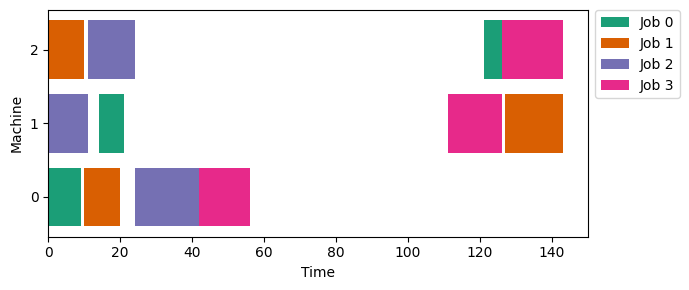

In [13]:
plot_horizontal(model)